In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [3]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
train_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),  
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(20),
    v2.RandomCrop(32, padding=4),  
    v2.Normalize(mean=mean,
                 std=std)  
])

dev_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(20),
    v2.RandomCrop(32, padding=4),
    v2.Normalize(mean=mean,
                 std=std)  
])

test_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),    
    v2.Normalize(mean=mean,
                 std=std)  
])

train_datasets = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
dev_datasets = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=dev_transform)
test_datasets = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=256, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_datasets, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=256, shuffle=True)

100%|██████████| 170M/170M [00:02<00:00, 78.5MB/s]


In [4]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Output: 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 64x16x16

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 128x8x8

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Output: 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 256x4x4

            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [5]:
model = CustomCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
num_epochs = 10
train_loss_list = []
train_acc_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

Epoch [1/10], Loss: 1.8343, Accuracy: 33.32%
Epoch [2/10], Loss: 1.4887, Accuracy: 45.04%
Epoch [3/10], Loss: 1.3559, Accuracy: 50.31%
Epoch [4/10], Loss: 1.2715, Accuracy: 53.85%
Epoch [5/10], Loss: 1.2018, Accuracy: 56.63%
Epoch [6/10], Loss: 1.1467, Accuracy: 58.86%
Epoch [7/10], Loss: 1.1173, Accuracy: 60.18%
Epoch [8/10], Loss: 1.0832, Accuracy: 61.89%
Epoch [9/10], Loss: 1.0414, Accuracy: 63.12%
Epoch [10/10], Loss: 1.0302, Accuracy: 63.51%


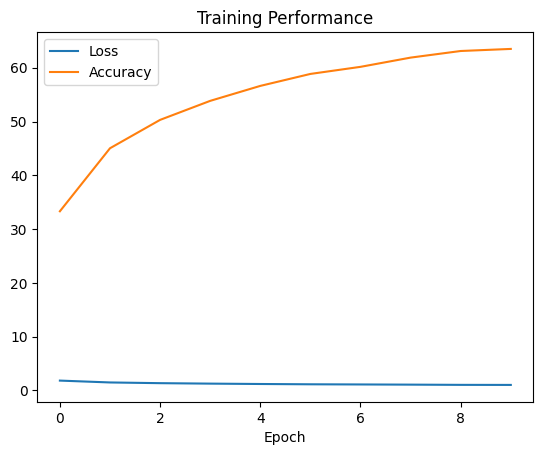

In [7]:
plt.plot(train_loss_list, label='Loss')
plt.plot(train_acc_list, label='Accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Performance")
plt.show()

In [8]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 70.92%


In [9]:
classes = train_datasets.classes
class_correct = [0 for _ in range(10)]
class_total = [0 for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nClass-wise Accuracy:")
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"{classes[i]}: {accuracy:.2f}%")


Class-wise Accuracy:
airplane: 74.80%
automobile: 86.00%
bird: 50.00%
cat: 47.50%
deer: 57.90%
dog: 74.60%
frog: 76.10%
horse: 71.40%
ship: 81.30%
truck: 89.60%
